# Exploring election contributions from FollowTheMoney.org

![FollowTheMoney](http://followthemoney.org/themes/ftm/images/logo.png)

## Motivation

I quickly created this notebook for a non-profit organization that was interested in improving existing workflows, as well as developing new products. It demonstrates programmatic methods for accessing data via an API, my thinking on cleaning and formatting data prior to usage, and simple modeling and visualization techniques.

## Overview

Here, our goal is to access political contribution data and uncover simple relationships between contributions and candidates. For this exploration, we use the political contribution data available at FollowTheMoney.org, which is curated by the nonpartisan, nonprofit National Institute on Money in State Politics. Their mission is to:

>promote an accountable democracy by compiling comprehensive campaign-donor, lobbyist, and other information from government disclosure agencies nationwide and making it freely available at FollowTheMoney.org,

and their website is a fantastic resource. Check it out!

First, we access a subset of data from their API. Second, we review, clean, and format this data. Third, we fit simple models to quantitatively describe the data and create simple visualizations.

## I. Access data

The following functions collectively access data from the FollowTheMoney.org API. In this particular section, we create a series of lower-level functions to interact with the API. Later, we use a higher-level, convenience function to manage to process of downloading records from the API. Note that I am obscuring my API key in the public notebook, and that I use a leading underscore to differentiate hidden lower-level function from convenience methods.

In [34]:
import json
import requests

URL_BASE = 'http://api.followthemoney.org/?'

_API_KEY = '{API_KEY}'
URL_CONFIG = 'APIKey={api_key}a&mode=json'.format(api_key=_API_KEY)


def _construct_url_for_all_records_api_query(state, year):
    """
    Construct the base URL for contribution records for a given state
    and year. The obscure alphaetic codes in the url_components are URL
    elements that tell the server we want an extended set of variables
    for each record.
    """
    url_components = ['s=' + state,
                      'y=' + year,
                      'f-core=1',
                      'gro=d-id,c-t-id,c-t-sts',
                      URL_CONFIG]
    return URL_BASE + '&'.join(url_components)    


def _get_number_of_pages_and_records_for_api_query(url):
    """
    Get the number of pages of records, as well as the number of total
    records, for a given API URL. Used to page through data and confirm
    all data has been downloaded.
    """
    response = json.loads(requests.get(url).text)
    num_pages = response['metaInfo']['paging']['totalPages']
    num_records = response['metaInfo']['paging']['totalRecords']
    return (num_pages, num_records)


def _get_all_records_for_api_query(url, num_pages):
    """
    Use the base API URL and number of total pages to iterate through
    all available records. Also print the progress of the record
    download.
    """
    records = []
    for page in range(0, num_pages):
        print '\rPage' + str(page+1) + ' out of ' + str(num_pages) + \
            ':  ' + str(page+1 / num_page) + '%', 
        url_page = url + '&p=' + str(page)
        response = json.loads(requests.get(url_page).text)
        records.extend(response['records'])
    return records


def _check_number_of_records_retrieved(records, num_records):
    """
    Raise an error if the total number of downloaded records does
    not match the total number of available records.
    """
    if len(records) != int(num_records):
        raise AssertionError(
            'Number of records retrieved is not equal to the number ' +
            'of records expected.')
    return

The following function is a higher-level convenience method to call each of the lower-level functions above, eventually returning a list of all contribution records for all candidates in a given state and year.

In [35]:
def get_all_records_for_state_and_year(state, year):
    """
    Convenience method for interacting with FollowTheMoney.org API.
    Constructs the base URL, iterates through all pages to access all
    records, and confirms that all records have been downloaded.
    """
    base_url = _construct_url_for_all_records_api_query(state, year)
    num_pages, num_records = \
        _get_number_of_pages_and_records_for_api_query(base_url)
    records = _get_all_records_for_api_query(base_url, num_pages)
    _check_number_of_records_retrieved(records, num_records)
    return records

Here, we use the above functions to get all contribution records for Arkansas in 2012. We output the data to a JSON file on our local storage, as the actual API interaction is not instantaneous and we can be considerate by not hammering their server each time we want the same data. Note that this is commented out because I have already downloaded the data prior to formatting this notebook.

In [36]:
state = 'AR'
year = '2012'
"""
ar_records = get_all_records_for_state_and_year(state, year)
"""

_LOCAL_PATH = '{PATH_TO_LOCAL_FILE}'
"""
with open(_LOCAL_PATH, 'w') as file_:
    file_.write(json.dumps(ar_records))
"""
print ''

## II. Review data

We want to review and understand the data prior to cleaning and formatting, because data availability will determine what models and visualizations we would like to create. We load data from the local files first.

In [37]:
# Import data from the local files
with open(_LOCAL_PATH) as file_:
    ar_records = json.loads(file_.readlines()[0])

We then explore the data to understand what information is captured in this dataset.

In [38]:
# Identify interesting variable categories from API documentation
variable_keys = \
    ['Broad_Sector', 'Election_Status', 'General_Industry', 
     'Incumbency_Status', 'Office_Sought', 'Specific_Business',
     'Status_of_Candidate', 'Type_of_Contributor', 'Type_of_Transaction']

# Create a data object to hold unique values for each variable category
possible_values = {key: set() for key in variable_keys}

# Iterate through records to access unique values
for record in ar_records:
    for key, set_ in possible_values.items():
        set_.add(record[key][key])

# Print out a sample of unique values for each variable category
# Note:  I explored these in more depth outside this notebook
for category, values in possible_values.items():
    print {category: list(values)[:5]}, '\n'

{'Office_Sought': [u'SUPREME COURT-POSITION 004', u'SENATE DISTRICT 035', u'US HOUSE DISTRICT AR 003', u'US HOUSE DISTRICT AR 002', u'HOUSE DISTRICT 053']} 

{'Election_Status': [u'Default Winner-Primary', u'Withdrew-General', u'Lost-General', u'Won-General', u'Disqualified-General']} 

{'Type_of_Transaction': [u'EH', u'CC', u'L', u'I', u'UI']} 

{'Status_of_Candidate': [u'Disqualified', u'Won', u'Withdrew', u'Default Winner', u'Lost']} 

{'Specific_Business': [u'Homemakers, students & other non-income earners', u'Hardware & tools', u'Telephone utilities', u'Television production', u'Air freight']} 

{'Incumbency_Status': [u'Challenger', u'Open', u'Incumbent']} 

{'Broad_Sector': [u'Party', u'Transportation', u'Defense', u'Energy & Natural Resources', u'Communications & Electronics']} 

{'General_Industry': [u'TV & Movie Production/Distribution', u'Recreation & Live Entertainment', u'Hunting', u'No Employer Listed or Found', u'Securities & Investment']} 

{'Type_of_Contributor': [u'Non

I conducted a separate, in-depth exploration of available data, with the following takeaways:

1.  **Broad_Sector**, **General_Industry**, and **Specific_Business** can be used to filter out candidate and party contributions. This would be an important step because contributions from individuals or groups are the focus of our analysis, and contributions or loans from candidates to themselves, or from parties to their candidates, can obscure meaningful patterns.  

2.  We would likely want to slice on different data dimensions to more accurately model the underlying patterns in the data. For instance, **Election_Status** and **Date** can be used to compare contributions for primaries and general elections separately, and **Office_Sought** can be used to compare contributions at different levels of government. If we ignore this step, it will be more difficult to find important relationships between contributions and candidates.

3.  **Type_of_Transaction** can be used to filter on particular contributions, but the documentation does not ennumerate what each code means. We can dig deeper if we'd like to use this information in a productive manner. I'd guess that "DIR" = direct contribution, "I" = in-kind contribution, but I'd want to contact the maintainers to understand the full list.

## III. Format data

Although we restricted our data access to Arkansas in 2012, the available data is still incredibly rich. To focus our analysis for this demonstration, we will slice the data to only include candidates running for state house seats in general elections. We meet the former requirement by filtering records such that "Office_Sought" matches "HOUSE DISTRICT X". We meet the latter requirement by filtering records such that "Candidate_Status" is one of "Lost-General", "Withdrew-General", or "Won-General".

While filtering the records to get contributions to candidates for state house seats in general elections, we return a formatted version of the contribution data so that we can create models and visualizations more easily. Specifically, we aggregate records for each candidate, record party affiliation and information about the candidate, and create lists of individual and non-individual contributions.

Again, the logic here is complex, so we use lower-level function to complete simple tasks and a higher-level function to iterate through records.

In [39]:
import re

def _check_record_for_filter_criteria(record):
    """
    Check if a record is a general election house race by matching on
    known values.
    """
    # First filter is house district contributions
    office_sought = record['Office_Sought']['Office_Sought']
    if re.search('HOUSE DISTRICT', office_sought) is None:
        return False
    # Second filter is general election contributions
    election_status = record['Election_Status']['Election_Status']
    valid_statuses = ['Lost-General', 'Withdrew-General', 'Won-General']
    if election_status not in valid_statuses:
        return False
    return True


def _parse_candidate_information_from_record(record):
    """
    Parse variables from each record to facilitate downstream analyses and
    visualizations.
    """
    # Remove parenthetical nicknames
    candidate = record['Candidate']['Candidate'].lower()
    candidate = re.split(' \(', candidate)[0]
    # Parse values
    office = record['Office_Sought']['Office_Sought']
    outcome = record['Election_Status']['Election_Status'].lower()
    party = record['General_Party']['General_Party'].lower()
    incumbency = record['Incumbency_Status']['Incumbency_Status'].lower()
    contributor_type = record['Type_of_Contributor']['Type_of_Contributor'].lower()
    amount = float(record['Amount']['Amount'])
    # Return dictionary of values
    return {'candidate': candidate, 'office': office, 'outcome': outcome,
            'party': party, 'incumbency': incumbency,
            'contributor_type': contributor_type, 'amount': amount}


def _update_candidates_with_candidate_information(candidates, candidate):
    """
    Update candidate information with information from a single record.
    """
    # Create or get candidate entry in candidates dictionary
    candidate_entry = candidates.setdefault(candidate['candidate'], {})
    # Create or add metainformation values to candidate metainformation
    # Track all metainformation in sets to catch instances of multiple values
    metainformation_keys = ['office', 'outcome', 'party', 'incumbency']
    for key in metainformation_keys:
        candidate_entry.setdefault(key, set()).add(candidate[key])
    # Create or add candidate contribution type and amount
    contributions = candidate_entry.setdefault('amount', {})
    contributions.setdefault(candidate['contributor_type'], [])\
        .append(candidate['amount'])
    return candidates


def _calculate_total_contributions_for_each_candidate(candidates):
    """
    Calculate total contribution amounts after all candidate information
    has been parsed and aggregated.
    """
    # Iterate through each candidate
    for candidate_entry in candidates.values():
        candidate_entry['total_amount'] = {}
        # Calculate total individual and non-individual contributions,
        # potentially other types
        for type_, amounts in candidate_entry['amount'].items():
            candidate_entry['total_amount'].update({type_: sum(amounts)})
    return candidates


def format_records_for_preliminary_analysis(records):
    """
    Iterate through all contribution records and aggregate data at the
    level of candidates.
    """
    # Create data object to hold information for all candidates
    candidates = {}
    # Iterate through records, get candidate data and update data object
    for record in records:
        if _check_record_for_filter_criteria(record) is False:
            continue
        candidate = _parse_candidate_information_from_record(record)
        candidates = _update_candidates_with_candidate_information(
            candidates, candidate)
    candidates = _calculate_total_contributions_for_each_candidate(
        candidates)
    return candidates

We can now format all raw records and briefly explore the output to illustrate the data format.

In [40]:
ar_data = format_records_for_preliminary_analysis(ar_records)

Here are a subset of candidates that meet our filtering criteria:

In [41]:
for candidate in ar_data.keys()[:5]:
    print '  ' + candidate

  richey, chris
  berry, robert
  lane, sam
  george, jim
  bell, nate


Here is a sample of the metainformation values available for each candidate:

In [42]:
sample_data = ar_data['richey, chris']
metainformation_keys = ['office', 'outcome', 'party', 'incumbency']
for key in metainformation_keys:
    print key, ':  ', list(sample_data[key])[0]

office :   HOUSE DISTRICT 012
outcome :   won-general
party :   democratic
incumbency :   open


And here are sample plots of contributions and total contributions:

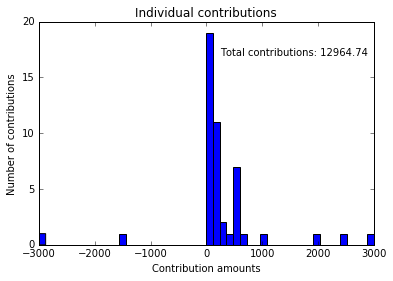

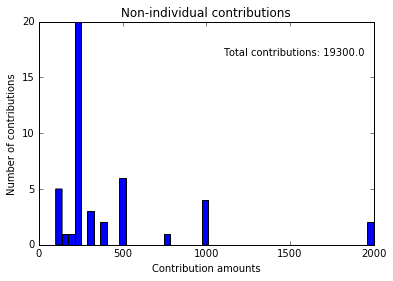

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt

# Visualizing the list of individual contributions
contributions = sample_data['amount']['individual']
total = sample_data['total_amount']['individual']
plt.hist(contributions, bins=50)
plt.title('Individual contributions')
plt.xlabel('Contribution amounts')
plt.ylabel('Number of contributions')
plt.text(250, 17, 'Total contributions: {}'.format(total))
plt.show()

# Visualizing the list of non-individual contributions
contributions = sample_data['amount']['non-individual']
total = sample_data['total_amount']['non-individual']
plt.hist(contributions, bins=50)
plt.title('Non-individual contributions')
plt.xlabel('Contribution amounts')
plt.ylabel('Number of contributions')
plt.text(1100, 17, 'Total contributions: {}'.format(total))
plt.show()

## IV. Analyze and visualize data

### Total contributions vs incumbency status

First, we'll look at the relationship between individual contributions, non-individual contributions, and incumbency status. The motivation for this exploration is redacted for proprietary reasons.

There are a few outliers in the contribution data -- candidates that pull in large amounts of funding relative to the median. I'm going to focus the visualiations on the candidates that are closer to the median contribution levels so that patterns are clearer.

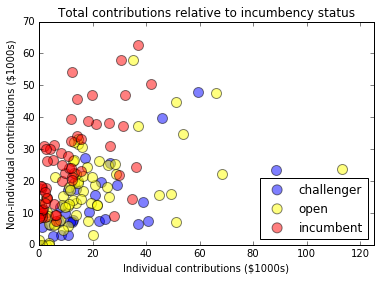

In [44]:
# Pull out data on total contributions by incumbency status for plotting
data = {}
for candidate in ar_data.values():
    # Get incumbency and a pointer to the incumbency type in the data
    incumbency = list(candidate['incumbency'])[0]
    pointer = data.setdefault(incumbency, {'individual': [], 'non-individual': []})
    # Record individual contributions
    amt_indiv = candidate['total_amount'].get('individual', 0)
    pointer['individual'].append(amt_indiv)
    # Record non-individual contributions
    amt_nonindiv = candidate['total_amount'].get('non-individual', 0)
    pointer['non-individual'].append(amt_nonindiv)


# Create plot
palette = {'challenger': 'blue', 'open': 'yellow', 'incumbent': 'red'}
plots = []
for incumbency, amounts in data.items():
    xs = [x / 1000. for x in amounts['individual']]
    ys = [y / 1000. for y in amounts['non-individual']]
    color = palette[incumbency]
    plots.append(plt.scatter(xs, ys, s=100, c=palette[incumbency], alpha=0.5))
plt.xlim((0, 125))
plt.ylim((0, 70))
plt.title('Total contributions relative to incumbency status')
plt.xlabel('Individual contributions ($1000s)')
plt.ylabel('Non-individual contributions ($1000s)')
plt.legend(plots, data.keys(), scatterpoints=1, loc='lower right')
plt.show()

This isn't terribly surprising, but it's still a neat pattern:  incumbents tend to have more non-individual contributions, relative to individual contributions, than challengers or candidates vying for an open seat.

It might be informative to fit a linear model to the data for each type of candidate. In this case, the model output would describe the expected ratio of individual to non-individual contributions as a function of incumbency.

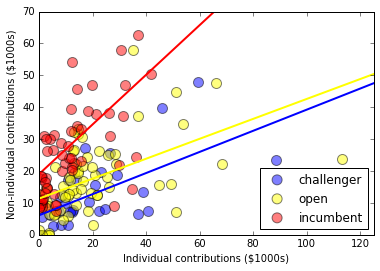

In [45]:
import numpy as np
import sklearn.linear_model

# Object to hold models
models = {}

# Fit linear model for each incumbency type and store parameters
regressor = sklearn.linear_model.LinearRegression()
for incumbency, amounts in data.items():
    xs = np.array(amounts['individual'])
    xs = xs.reshape([len(xs), 1])
    ys = np.array(amounts['non-individual'])
    ys = ys.reshape([len(ys), 1])
    regressor.fit(xs, ys)
    models[incumbency] = {'intercept': regressor.intercept_,
                          'coef': regressor.coef_}
    
# Recreate plot with models
plots = []
for incumbency, amounts in data.items():
    xs = [x / 1000. for x in amounts['individual']]
    ys = [y / 1000. for y in amounts['non-individual']]
    color = palette[incumbency]
    plots.append(plt.scatter(xs, ys, s=100, c=palette[incumbency], alpha=0.5))
plt.xlim((0, 125))
plt.ylim((0, 70))
plt.xlabel('Individual contributions ($1000s)')
plt.ylabel('Non-individual contributions ($1000s)')
plt.legend(plots, data.keys(), scatterpoints=1, loc='lower right')
for incumbency, model in models.items():
    b = model['intercept'] / 1000.
    a = model['coef']
    plt.plot([0, 125], [b, b + a*125], 'k-', c=palette[incumbency], lw=2)
plt.show()

I'm plotting the model predictions as lines that show the expected amount of non-individual contributions given an amount of individual contributions. Candidates who are vying for an open seat or challenging an incumbent get similar proportions of individual and non-individual contributions. In contrast, incumbent candidates get proportionally more non-individual contributions at an increasing rate. Incumbents have a non-individual advantage over candidates running for an open seat, which have an advantage over candidates challenging incumbents.

### Total contributions vs election outcome

I'm going to use the same visualization style to demonstrate how total individual and non-individual contributions are related to election outcomes. Again, the motivation for this exploration is redacted for proprietary reasons.

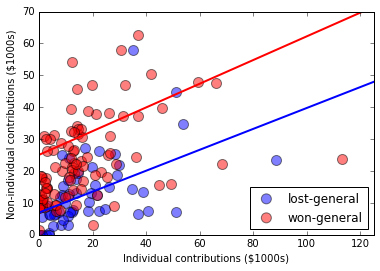

In [46]:
# Pull out data on total contributions by incumbency status
data = {}
for candidate in ar_data.values():
    incumbency = list(candidate['outcome'])[0]
    pointer = data.setdefault(incumbency, {'individual': [], 'non-individual': []})
    amt_indiv = candidate['total_amount'].get('individual', 0)
    pointer['individual'].append(amt_indiv)
    amt_nonindiv = candidate['total_amount'].get('non-individual', 0)
    pointer['non-individual'].append(amt_nonindiv)


# Object to hold models
models = {}

# Fit model for each incumbency type and store parameters
regressor = sklearn.linear_model.LinearRegression()
for incumbency, amounts in data.items():
    xs = np.array(amounts['individual'])
    xs = xs.reshape([len(xs), 1])
    ys = np.array(amounts['non-individual'])
    ys = ys.reshape([len(ys), 1])
    regressor.fit(xs, ys)
    models[incumbency] = {'intercept': regressor.intercept_,
                          'coef': regressor.coef_}
    
# Create plot
plots = []
palette = {'lost-general': 'blue', 'withdrew-general': 'yellow', 'won-general': 'red'}
for incumbency, amounts in data.items():
    xs = [x / 1000. for x in amounts['individual']]
    ys = [y / 1000. for y in amounts['non-individual']]
    color = palette[incumbency]
    plots.append(plt.scatter(xs, ys, s=100, c=palette[incumbency], alpha=0.5))
plt.xlim((0, 125))
plt.ylim((0, 70))
plt.xlabel('Individual contributions ($1000s)')
plt.ylabel('Non-individual contributions ($1000s)')
plt.legend(plots, data.keys(), scatterpoints=1, loc='lower right')
for incumbency, model in models.items():
    b = model['intercept'] / 1000.
    a = model['coef']
    plt.plot([0, 125], [b, b + a*125], 'k-', c=palette[incumbency], lw=2)
plt.show()

Candidates who win general elections tend to have greater non-individual contributions than candidates who lose general elections, as shown by the greater intercept of the red line. However, winning and losing candidates tend to pull in individual and non-individual contributions at the same rate, as shown by the similar slopes of the red and blue lines. 

To make this more clear, the average winning candidate will start with approxiately \$25,000 in non-individual contributions, while the average losing candidate will start with approximately \$7,000 in non-individual contributions. However, winning candidates pull in \$.37 in additional non-individual contributions for every \$1 in individual contributions, while losing candidates pull in \$.32 in additional non-individual contributions. 

Now, do winning candidates get more non-individual contributions because they're more likely to win, or do more non-individual contributions increase the chances of success? Our model can't address this question, but the answers are out there.

**Disclaimers for the above analyses:**

I've removed a couple of paragraphs and several visualizations to protect the proprietary interests of my partner non-profit.  

We would want to follow more rigorous steps if we were facilitating decision-making based on this dataset. For instance, we would look into how well the data fits model assumptions, whether our sample sizes are large enough to make inferences, and how well our models describe the data, among other steps.